## Libraries

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

## Define Model

In [37]:
class Sequence(nn.Module):
    hidden_size = 10
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(1, self.hidden_size)
        self.lstm2 = nn.LSTMCell(self.hidden_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, 1)

    def forward(self, input, future = 0):
        outputs = []
        h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.double)
        c_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), self.hidden_size, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), self.hidden_size, dtype=torch.double)

        for input_t in input.split(1, dim=1):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.cat(outputs, dim=1)
        return outputs

## Define parameters

In [38]:
#number of steps
opt = 15
# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)
# load data and make training set
data = torch.load('traindata.pt')
input = torch.from_numpy(data[3:, :-1])
target = torch.from_numpy(data[3:, 1:])
test_input = torch.from_numpy(data[:3, :-1])
test_target = torch.from_numpy(data[:3, 1:])
# build the model
seq = Sequence()
seq.double()
criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(seq.parameters(), lr=0.8, max_iter = 15)
#begin to train

## Training loop

In [39]:
future_preds = []
for i in range(opt):
  print('STEP: ', i+1)
  def closure():
      optimizer.zero_grad()
      out = seq(input)
      loss = criterion(out, target)
      print('loss:', loss.item())
      loss.backward()
      return loss
  optimizer.step(closure)
  # begin to predict, no need to track gradient here
  with torch.no_grad():
      future = 1000
      pred = seq(test_input, future=future)
      loss = criterion(pred[:, :-future], test_target)
      print('test loss:', loss.item())
      y = pred.detach().numpy()
      future_preds.append(y)

STEP:  1
loss: 0.5117297552810932
loss: 0.49442426197299777
loss: 0.47303436791335896
loss: 0.4329176022795622
loss: 0.2951026581999967
loss: 0.1697088663113154
loss: 0.0845774267039949
loss: 0.04927996153411935
loss: 0.039674400291972986
loss: 0.03858965848284361
loss: 0.036654788392317415
loss: 0.031347099728790344
loss: 0.026663365476370132
loss: 0.02002317248856867
loss: 0.014361331270365825
test loss: 0.01102590079195467
STEP:  2
loss: 0.011352115099279365
loss: 0.005609158310663694
loss: 0.00394721629123558
loss: 0.0023043914696675135
loss: 0.0015841828903378102
loss: 0.0011421430462742435
loss: 0.000929488908898959
loss: 0.0007375227793321009
loss: 0.0006587576800125542
loss: 0.0006280401249694746
loss: 0.0006157073222113238
loss: 0.000602609639362499
loss: 0.000576893771925267
loss: 0.000540148583542319
loss: 0.0004642545112363818
test loss: 0.00030072717920690586
STEP:  3
loss: 0.0003226081679671027
loss: 0.0003836155935955232
loss: 0.00024679499282042407
loss: 0.0002411898631

## Results

In [40]:
from IPython.display import Image
for i, future_pred in enumerate(future_preds):
  # draw the result
  plt.figure(figsize=(30,10))
  plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)
  plt.xlabel('x', fontsize=20)
  plt.ylabel('y', fontsize=20)
  def draw(yi, color):
    plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
    plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
  draw(future_pred[0], 'r')
  draw(future_pred[1], 'g')
  draw(future_pred[2], 'b')
  plt.savefig(f'predict{i+1}.jpg')
  plt.close()

### Iteration 1

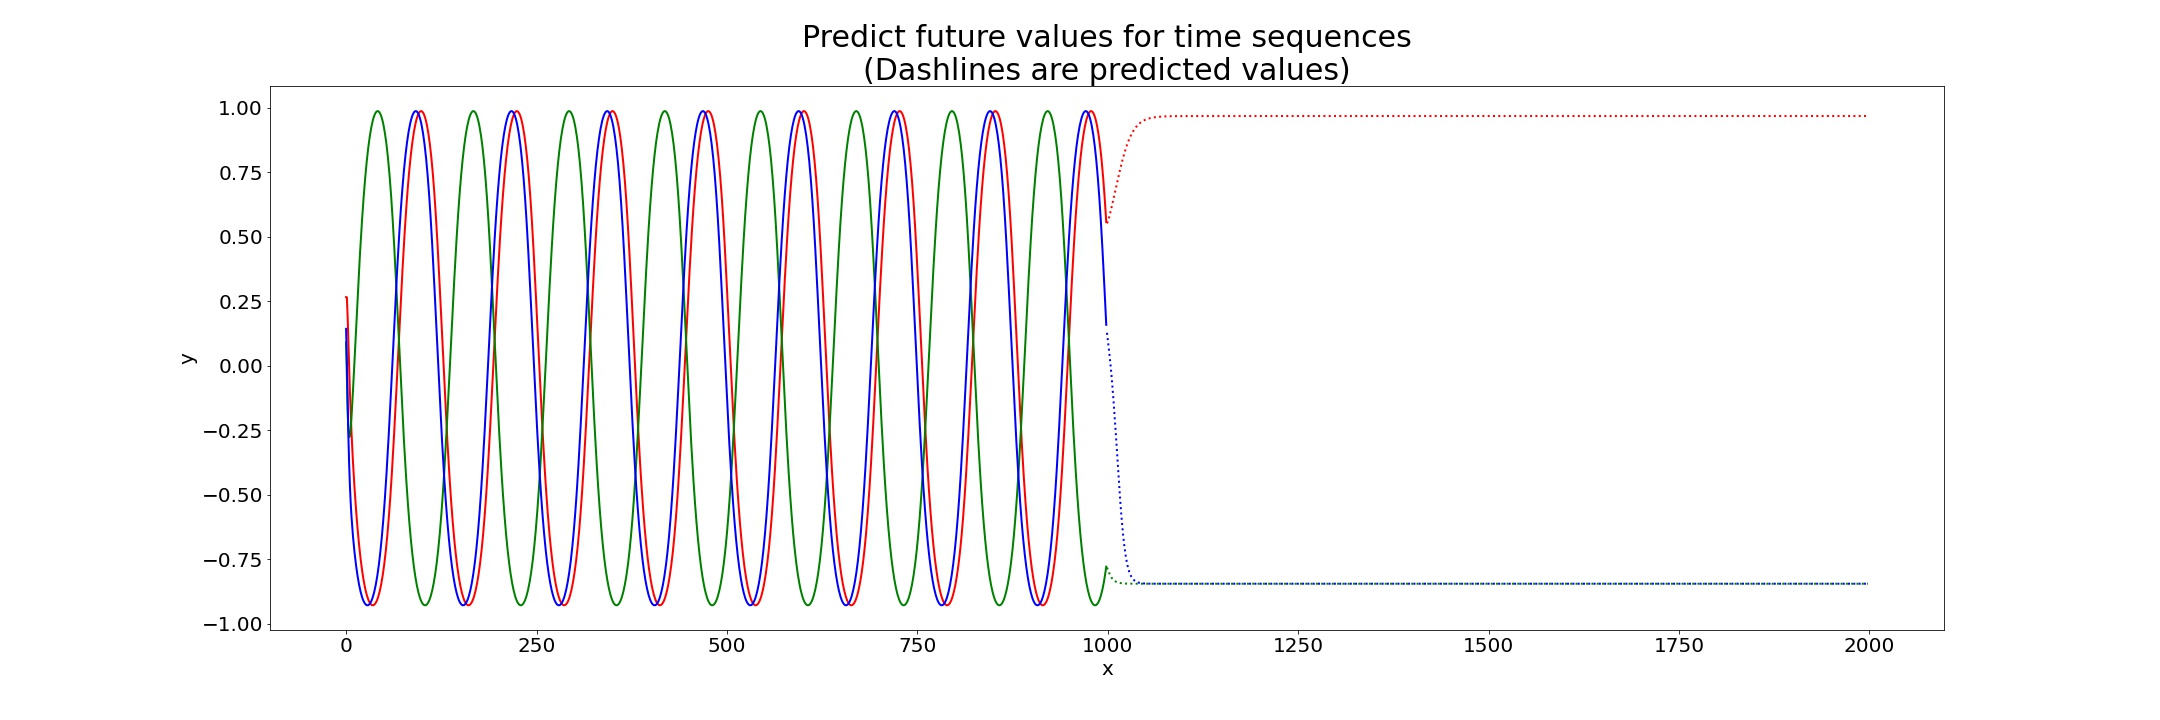

In [41]:
Image(f'predict1.jpg')

### Final Iteration

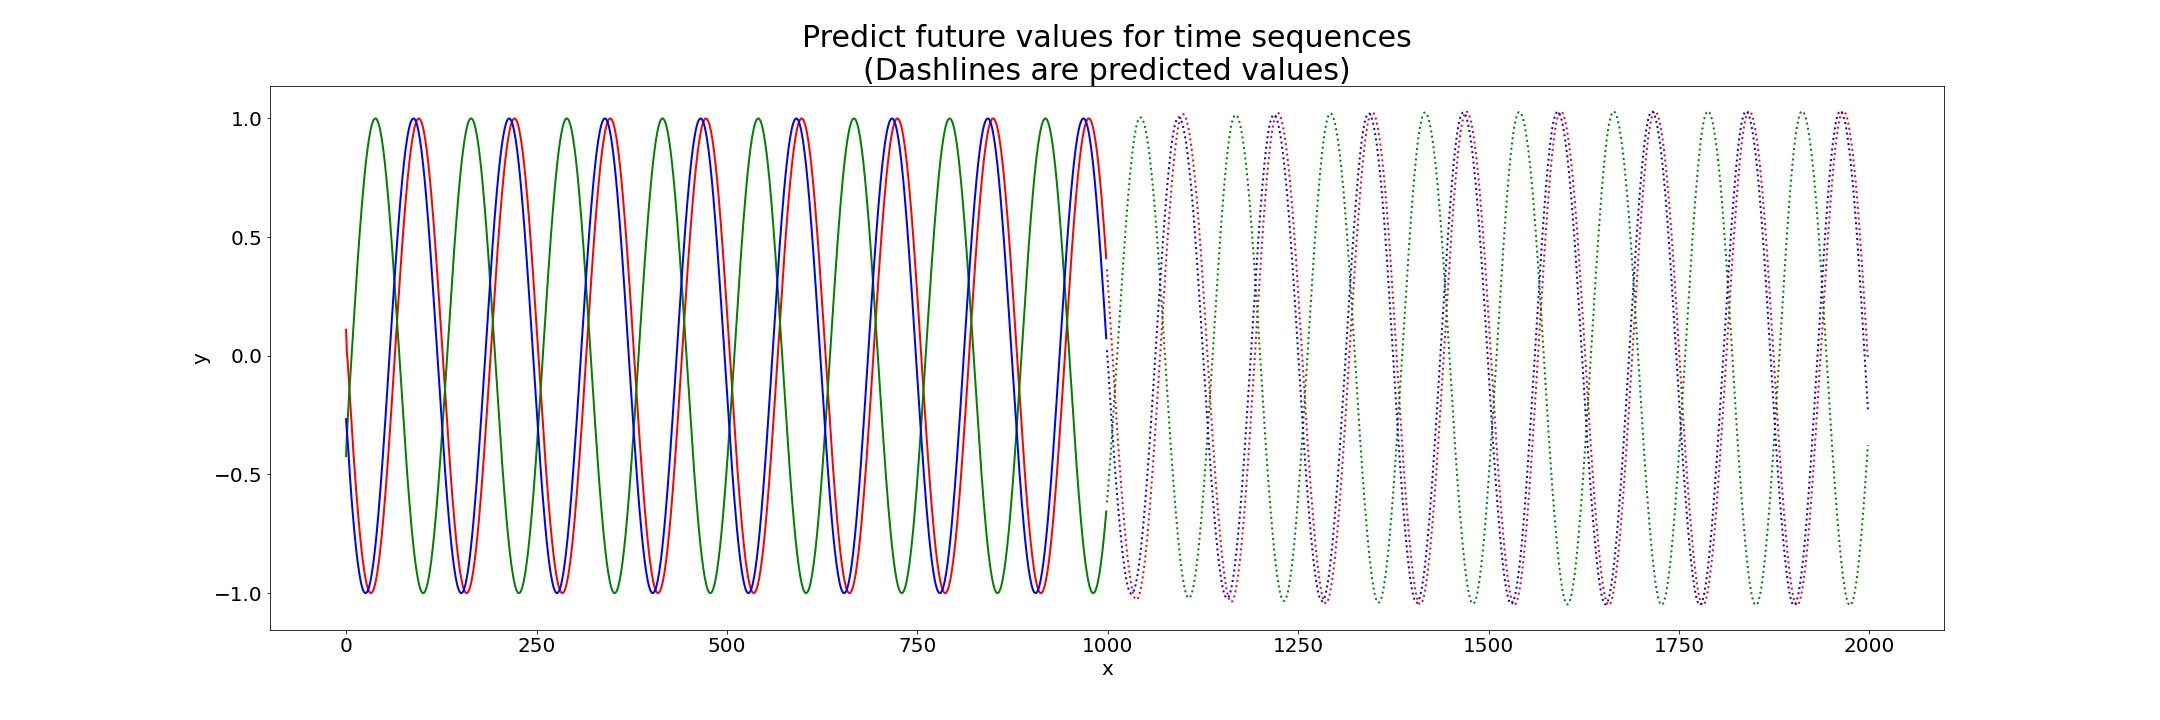

In [42]:
Image(f'predict{len(future_preds)}.jpg')